In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc


import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

data = pd.read_csv("../input/bs140513_032310.csv")
data.head(5)

Using TensorFlow backend.


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
step           594643 non-null int64
customer       594643 non-null object
age            594643 non-null object
gender         594643 non-null object
zipcodeOri     594643 non-null object
merchant       594643 non-null object
zipMerchant    594643 non-null object
category       594643 non-null object
amount         594643 non-null float64
fraud          594643 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


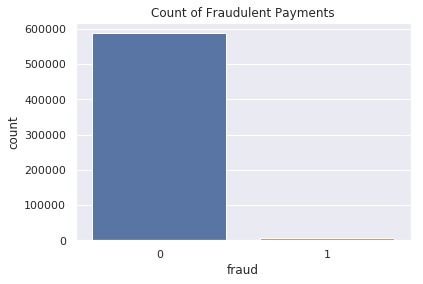

Number of normal examples:  587443
Number of fradulent examples:  7200


In [5]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

amount ,percentage of fraud and the categories of transactions

In [6]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


In [8]:
#Create two dataframes with fraud and non-fraud data 
## Catagories of transaction and statistics of Fraudulent and Non Fraudulent Categories

In [9]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000
'es_sportsandtoys',345.366811,88.502738,49.525237


No handles with labels found to put in legend.


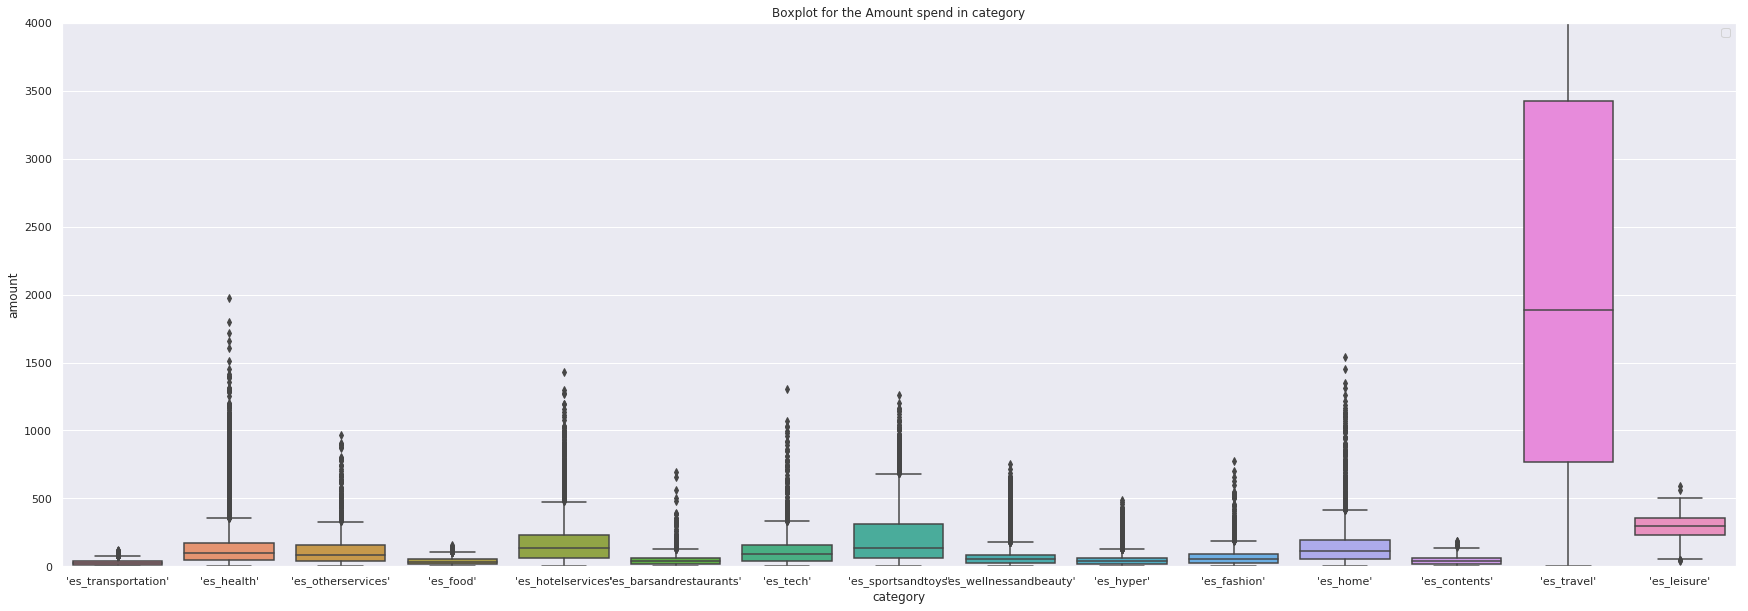

In [10]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

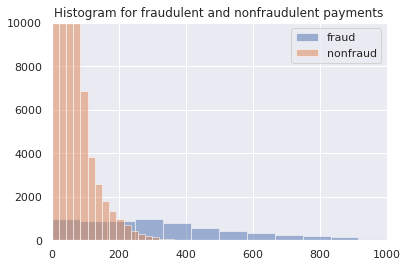

In [11]:
# histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

Data representation of age and probability of fraud

In [12]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


## Data Preprocessing



In [13]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [14]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [15]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)


In [16]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [17]:
y[y==1].count()

7200

## Oversampling with SMOTE

Using SMOTE(Synthetic Minority Oversampling Technique) for balancing the dataset. 
Resulted counts show that now we have exact number of class instances (1 and 0).

In [18]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res[0].value_counts())

1    587443
0    587443
Name: 0, dtype: int64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [20]:
# Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [21]:
print("Base accuracy score : ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score :  98.7891894800746


## **KNN Classifier**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

   micro avg       0.99      0.99      0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[172041   4192]
 [   376 175857]]


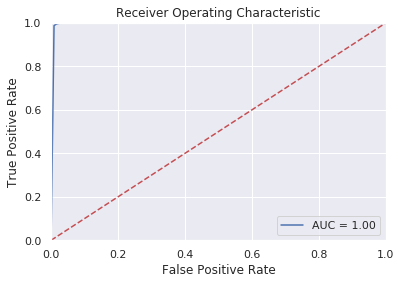

In [22]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

## **Random Forest Classifier**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    176233
           1       0.97      1.00      0.98    176233

   micro avg       0.98      0.98      0.98    352466
   macro avg       0.99      0.98      0.98    352466
weighted avg       0.99      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[171433   4800]
 [   583 175650]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


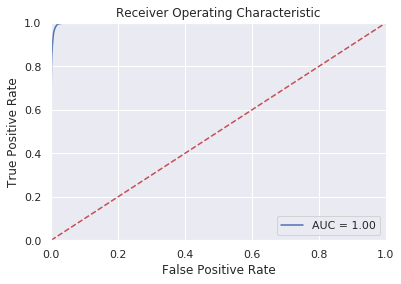

In [23]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

In [26]:
import joblib
joblib.dump(rf_clf,"rf_cf.pkl")


['rf_cf.pkl']

In [28]:
model = joblib.load('/kaggle/working/rf_cf.pkl')
y_predict = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


In [31]:
y_predict

array([1, 1, 0, ..., 0, 0, 0])

## XGBoost Classifier

In [ ]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=True)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
import joblib
joblib.dump(XGBoost_CLF,"rf_xboost.pkl")

['rf_xboost.pkl']

In [28]:
model = joblib.load('/kaggle/working/rf_xboost.pkl')
y_predict = model.predict(X_test)

In [29]:
y_predict

array([1, 1, 0, ..., 0, 0, 0])

In [37]:
import pandas as pd
import numpy as np

# Assuming X_test is a NumPy array
df = pd.DataFrame(X_test)
df.to_csv('X_test.csv', index=False)